<a href="https://colab.research.google.com/github/bmontoyag/UTEC_IA_Fundamentals/blob/main/Proyecto_final/Experimento_4_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar la biblioteca KaggleHub para interactuar con Kaggle
!pip install -q kagglehub

# Importar las bibliotecas necesarias para la gestión de archivos
import kagglehub
import os

# Descargar el dataset. 'data_dir' contendrá la ruta a la carpeta raíz descargada.
print("Descargando el dataset desde KaggleHub...")
data_dir = kagglehub.dataset_download("muhammadardiputra/potato-leaf-disease-dataset")
print(f"Dataset descargado en: {data_dir}")

# Verificamos el contenido para asegurarnos de la estructura de carpetas
# Esto nos ayuda a construir la ruta completa y correcta en el siguiente paso
print("Contenido de la carpeta descargada:", os.listdir(data_dir))

Descargando el dataset desde KaggleHub...


100%|██████████| 25.2M/25.2M [00:00<00:00, 133MB/s] 

Extracting files...


Dataset descargado en: /root/.cache/kagglehub/datasets/muhammadardiputra/potato-leaf-disease-dataset/versions/1
Contenido de la carpeta descargada: ['Potato']


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# --- Parámetros para el procesamiento y entrenamiento ---
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

# --- Construir la ruta completa al directorio que contiene Train/Test ---
# Basado en la inspección anterior, añadimos el nombre de la subcarpeta
data_dir_full = os.path.join(data_dir, "Potato")

# --- Cargar los datos de entrenamiento y validación (80/20) ---
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir_full, "Train"),
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="both",
    seed=123
)
train_dataset, validation_dataset = dataset

# --- Cargar los datos de prueba ---
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir_full, "Test"),
    shuffle=False,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Guardar los nombres de las clases (enfermedades)
class_names = train_dataset.class_names
print("\nClases detectadas:", class_names)

# --- Optimización del rendimiento del dataset ---
# Normaliza los valores de los píxeles al rango [0, 1] y usa caché para acelerar la carga
def normalize(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

train_dataset = train_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(normalize).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("\n¡Datos listos para el entrenamiento!")

Found 900 files belonging to 3 classes.
Using 720 files for training.
Using 180 files for validation.
Found 300 files belonging to 3 classes.

Clases detectadas: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

¡Datos listos para el entrenamiento!


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# --- Define input_shape and num_classes ---
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
num_classes = len(class_names)

# --- Cargar el modelo base pre-entrenado (MobileNetV2) ---
# Se carga sin la capa final de clasificación (include_top=False)
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# --- Congelar el modelo base ---
# No queremos re-entrenar las capas que ya aprendieron características generales
base_model.trainable = False

# --- Añadir nuestras propias capas de clasificación ---
# Tomamos la salida del modelo base y le añadimos nuestras capas
x = base_model.output
x = layers.GlobalAveragePooling2D()(x) # Reduce la dimensionalidad
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

# --- Construir el modelo final ---
model_transfer = Model(inputs=base_model.input, outputs=output_layer)

# --- Compilar y entrenar ---
model_transfer.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model_transfer.summary()

# Ahora, entrena 'model_transfer' en lugar del modelo original
# history = model_transfer.fit(...)

/tmp/ipython-input-4-1107062120.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
print("\nIniciando el entrenamiento del modelo...")

history = model_transfer.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_dataset,
    verbose=1,
)

print("\n Entrenamiento completado.")


Iniciando el entrenamiento del modelo...
Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6715 - loss: 0.7702 - val_accuracy: 0.9556 - val_loss: 0.1695
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9366 - loss: 0.2026 - val_accuracy: 0.9500 - val_loss: 0.1381
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9625 - loss: 0.1147 - val_accuracy: 0.9722 - val_loss: 0.0889
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9890 - loss: 0.0652 - val_accuracy: 0.9722 - val_loss: 0.0717
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9811 - loss: 0.0679 - val_accuracy: 0.9722 - val_loss: 0.0697
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9922 - loss: 0.0423 - val_accuracy: 0.9722 - val_loss: 0.0592
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9910 - loss: 0.0346 - val_accuracy: 0.9722 - val_loss: 0.0573
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9998 - loss:

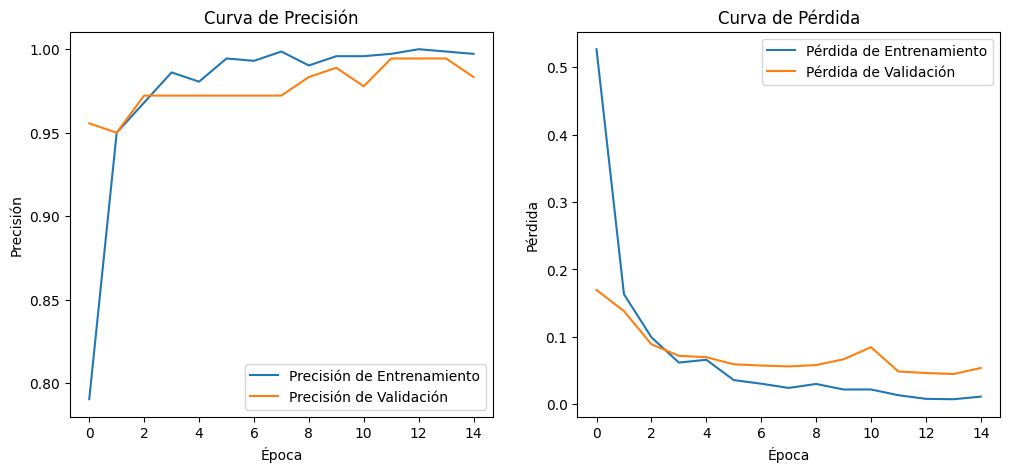


Evaluando el modelo con los datos de prueba...
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9821 - loss: 0.0352

 Precisión final en el conjunto de prueba: 98.33%


In [ ]:
# --- Gráficas de Precisión y Pérdida durante el entrenamiento ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Precisión de Entrenamiento')
plt.plot(range(EPOCHS), val_acc, label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Curva de Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Pérdida de Entrenamiento')
plt.plot(range(EPOCHS), val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Curva de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

# --- Evaluación final con el conjunto de prueba ---
print("\nEvaluando el modelo con los datos de prueba...")
test_loss, test_acc = model_transfer.evaluate(test_dataset)
print(f"\n Precisión final en el conjunto de prueba: {test_acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


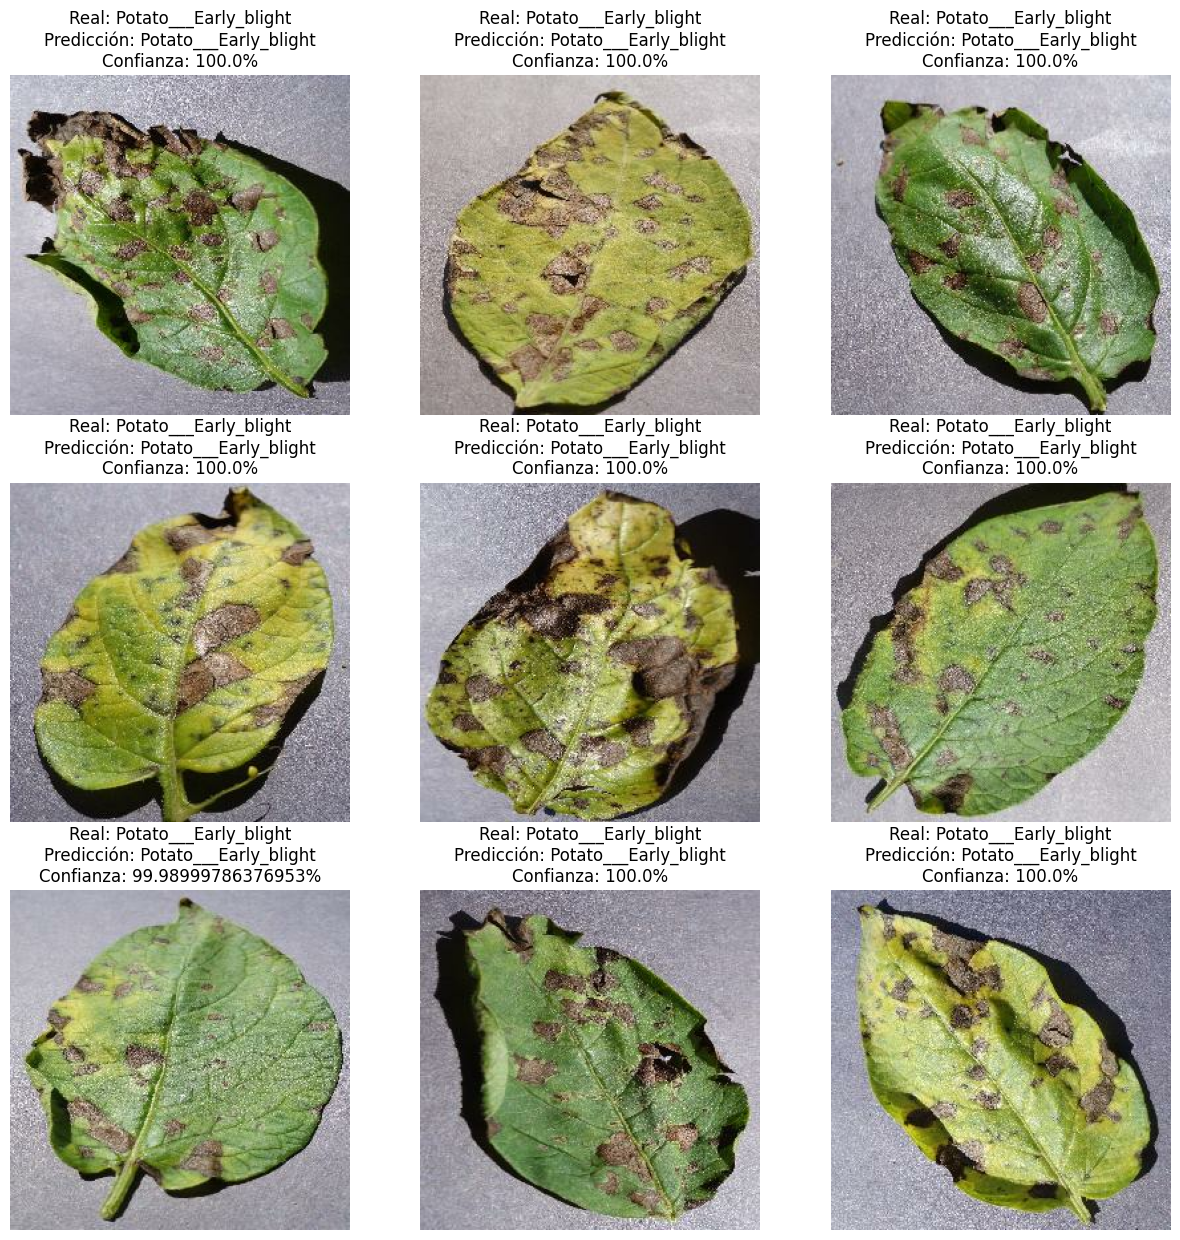

In [ ]:
import numpy as np

# --- Función para predecir una sola imagen ---
def predict_image(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Crear un lote de una sola imagen

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# --- Visualizar predicciones en un conjunto de imágenes de prueba ---
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):  # Mostramos las primeras 9 imágenes
        ax = plt.subplot(3, 3, i + 1)
        # Unnormalize images before displaying
        plt.imshow((images[i].numpy() * 255).astype("uint8"))

        predicted_class, confidence = predict_image(model_transfer, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Real: {actual_class}\nPredicción: {predicted_class}\nConfianza: {confidence}%")
        plt.axis("off")